In [3]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as im
import amglib.readers as io
from tqdm.notebook import tqdm
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import cbct
import importlib


In [10]:
importlib.reload(cbct)

<module 'cbct' from 'C:\\Users\\kaestner\\git\\CBCTCalibration\\cbct.py'>

In [5]:
datapath="E:/Kaestner/P20200166Cramer/02_CBCTCal/"

In [6]:
dc=io.read_images(datapath+'dc_{:05}.fits',first=1,last=10,averageStack=True,average='mean');
ob=io.read_images(datapath+'ob_{:05}.fits',first=1,last=10,averageStack=True,average='mean');
cal=io.read_images(datapath+'cbctcal_{:05}.fits',first=1,last=360,stride=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

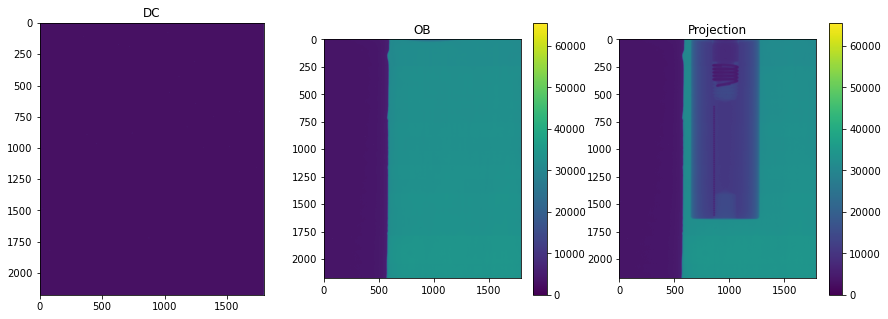

In [9]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax=ax.ravel()
ax[0].imshow(dc)
ax[0].set_title('DC')
a1=ax[1].imshow(ob)
fig.colorbar(a1,ax=ax[1])
ax[1].set_title('OB')
a2=ax[2].imshow(cal[1,:,:]) #,vmin=0.0,vmax=10000)
fig.colorbar(a2,ax=ax[2])
ax[2].set_title('Projection');

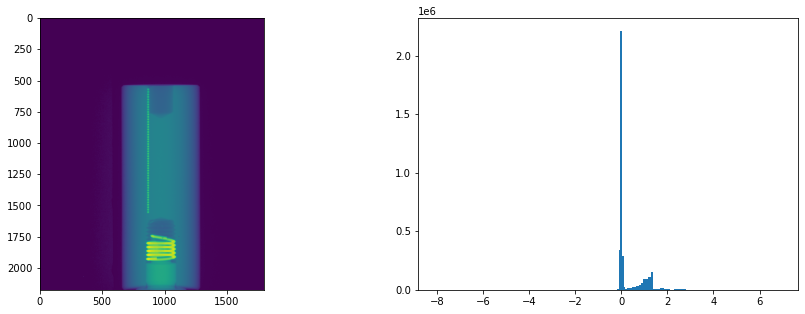

In [12]:
lcal=cbct.normalizeData(cal,ob,dc)
flipProjection = True
if flipProjection : 
    lcal = lcal[:,::-1,:]
    
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(lcal[1],vmin=0,vmax=3)
ax[1].hist(lcal[1].ravel(),bins=200);